In [1]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm


Using TensorFlow backend.


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [3]:
start = dt.datetime.now()

In [5]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
	os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
	os.makedirs(models_dir)

In [6]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
	os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
	os.makedirs(models_dir)


In [9]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
              'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [12]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = '/Users/zakopuro/Documents/kaggle/Plant_Seedlings/input/plant-seedlings-classification/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))


In [13]:
sample_submission.head(2)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet


In [14]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [15]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

,file,category_id,category
0,train/Black-grass/5a1295fb4.png,0,Black-grass
1,train/Black-grass/d8afd58f3.png,0,Black-grass


(4750, 3)

In [16]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape

,file,category_id,category
0,train/Cleavers/4613b263e.png,2,Cleavers
1,train/Common Chickweed/fd08aae02.png,3,Common Chickweed


(2400, 3)

In [17]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

,filepath,file
0,test/1b490196c.png,1b490196c.png
1,test/85431c075.png,85431c075.png


(794, 2)

In [18]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

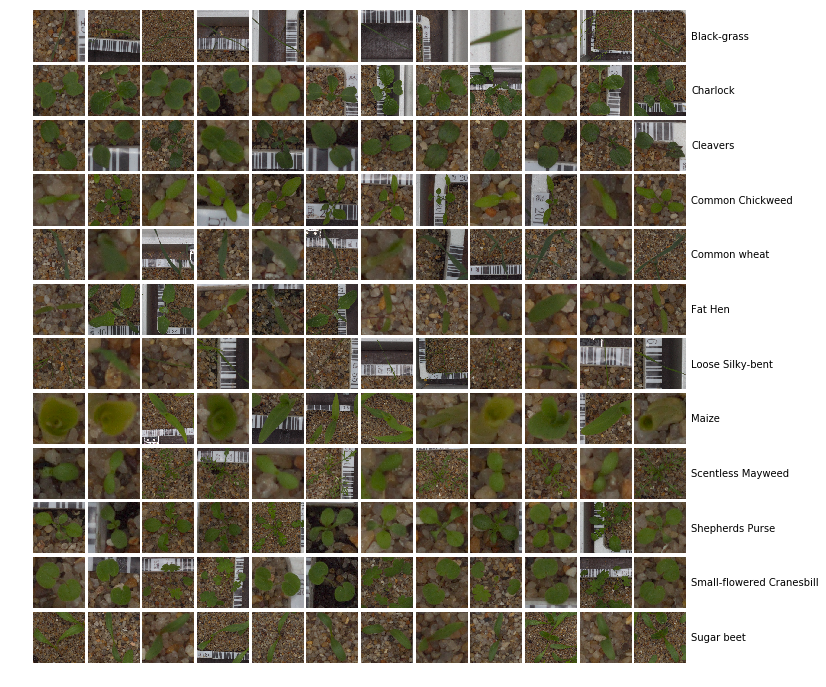

In [19]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [20]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [21]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

0it [00:00, ?it/s]

1it [00:00,  6.78it/s]

10it [00:00,  9.37it/s]

17it [00:00, 12.60it/s]

21it [00:00, 15.06it/s]

36it [00:00, 20.53it/s]

45it [00:00, 25.98it/s]

53it [00:00, 32.53it/s]

62it [00:00, 39.52it/s]

70it [00:01, 46.22it/s]

78it [00:01, 47.25it/s]

85it [00:01, 50.18it/s]

92it [00:01, 48.37it/s]

98it [00:01, 44.92it/s]

112it [00:01, 55.97it/s]

122it [00:02, 44.79it/s]

129it [00:02, 47.30it/s]

140it [00:02, 55.41it/s]

147it [00:02, 53.73it/s]

154it [00:02, 55.27it/s]

161it [00:02, 57.36it/s]

168it [00:02, 52.29it/s]

175it [00:02, 55.20it/s]

185it [00:03, 63.47it/s]

193it [00:03, 60.38it/s]

200it [00:03, 61.74it/s]

207it [00:03, 41.74it/s]

219it [00:03, 51.61it/s]

229it [00:03, 50.63it/s]

239it [00:04, 58.28it/s]

247it [00:04, 63.07it/s]

256it [00:04, 66.88it/s]

270it [00:04, 71.75it/s]

279it [00:04, 73.96it/s]

289it [00:04, 73.19it/s]

297it [00:05, 46.00it/s]

309it [00:05, 56.31it/s]

317it [00:05, 60.63it/s]

325it [00:05, 58.03it/s]

332it [00:05, 51.56it/s]

339it [00:05, 53.05it/s]

346it [00:05, 55.06it/s]

355it [00:05, 60.27it/s]

364it [00:06, 65.07it/s]

371it [00:06, 65.73it/s]

378it [00:06, 57.47it/s]

389it [00:06, 65.41it/s]

397it [00:06, 64.63it/s]

404it [00:06, 63.85it/s]

412it [00:06, 67.93it/s]

429it [00:06, 80.52it/s]

439it [00:06, 82.74it/s]

449it [00:07, 82.69it/s]

467it [00:07, 97.62it/s]

479it [00:07, 100.54it/s]

491it [00:07, 94.05it/s] 

502it [00:07, 74.34it/s]

511it [00:07, 71.46it/s]

520it [00:07, 65.53it/s]

528it [00:08, 67.64it/s]

536it [00:08, 46.28it/s]

542it [00:08, 48.02it/s]

548it [00:08, 50.52it/s]

556it [00:08, 56.31it/s]

563it [00:08, 53.96it/s]

573it [00:08, 62.03it/s]

587it [00:09, 72.46it/s]

596it [00:09, 63.87it/s]

608it [00:09, 73.87it/s]

618it [00:09, 76.76it/s]

627it [00:09, 78.56it/s]

636it [00:09, 81.03it/s]

645it [00:09, 59.98it/s]

655it [00:10, 66.42it/s]

665it [00:10, 72.48it/s]

674it [00:10, 75.92it/s]

683it [00:10, 72.96it/s]

694it [00:10, 79.46it/s]

703it [00:10, 76.75it/s]

713it [00:10, 77.81it/s]

723it [00:10, 82.93it/s]

734it [00:10, 85.49it/s]

743it [00:11, 66.06it/s]

751it [00:11, 64.47it/s]

761it [00:11, 72.07it/s]

769it [00:11, 52.83it/s]

777it [00:11, 56.85it/s]

787it [00:11, 62.82it/s]

795it [00:12, 52.15it/s]

802it [00:12, 51.86it/s]

808it [00:12, 46.26it/s]

824it [00:12, 58.01it/s]

834it [00:12, 65.01it/s]

846it [00:12, 75.20it/s]

856it [00:12, 74.23it/s]

865it [00:12, 75.35it/s]

875it [00:13, 80.81it/s]

885it [00:13, 84.24it/s]

898it [00:13, 90.92it/s]

908it [00:13, 73.73it/s]

917it [00:13, 77.84it/s]

926it [00:13, 74.84it/s]

934it [00:13, 69.16it/s]

945it [00:13, 76.18it/s]

956it [00:14, 83.63it/s]

967it [00:14, 89.18it/s]

977it [00:14, 89.25it/s]

987it [00:14, 89.36it/s]

997it [00:14, 84.30it/s]

1006it [00:14, 79.17it/s]

1018it [00:14, 86.34it/s]

1027it [00:14, 73.09it/s]

1036it [00:15, 74.49it/s]

1044it [00:15, 76.00it/s]

1052it [00:15, 76.18it/s]

1064it [00:15, 84.24it/s]

1073it [00:15, 78.12it/s]

1082it [00:15, 64.97it/s]

1090it [00:15, 60.03it/s]

1098it [00:15, 62.14it/s]

1105it [00:16, 52.27it/s]

1114it [00:16, 58.25it/s]

1121it [00:16, 55.38it/s]

1130it [00:16, 60.27it/s]

1143it [00:16, 70.62it/s]

1152it [00:16, 75.24it/s]

1162it [00:16, 80.26it/s]

1171it [00:16, 76.63it/s]

1180it [00:17, 54.56it/s]

1187it [00:17, 43.66it/s]

1196it [00:17, 47.09it/s]

1203it [00:17, 49.66it/s]

1213it [00:17, 58.12it/s]

1220it [00:17, 59.45it/s]

1227it [00:18, 60.38it/s]

1236it [00:18, 66.48it/s]

1249it [00:18, 77.40it/s]

1258it [00:18, 79.81it/s]

1267it [00:18, 68.92it/s]

1279it [00:18, 69.77it/s]

1289it [00:18, 66.72it/s]

1297it [00:19, 53.02it/s]

1309it [00:19, 61.70it/s]

1320it [00:19, 70.54it/s]

1339it [00:19, 86.44it/s]

1352it [00:19, 86.62it/s]

1363it [00:19, 83.21it/s]

1374it [00:19, 69.28it/s]

1385it [00:20, 74.72it/s]

1395it [00:20, 72.30it/s]

1404it [00:20, 76.21it/s]

1413it [00:20, 79.20it/s]

1422it [00:20, 79.70it/s]

1438it [00:20, 84.71it/s]

1450it [00:20, 92.33it/s]

1462it [00:20, 99.16it/s]

1473it [00:21, 97.49it/s]

1484it [00:21, 84.81it/s]

1493it [00:21, 74.18it/s]

1502it [00:21, 59.16it/s]

1509it [00:21, 61.58it/s]

1518it [00:21, 62.13it/s]

1525it [00:22, 45.61it/s]

1534it [00:22, 53.48it/s]

1551it [00:22, 67.28it/s]

1561it [00:22, 68.83it/s]

1572it [00:22, 77.14it/s]

1582it [00:22, 78.49it/s]

1593it [00:22, 85.70it/s]

1603it [00:22, 84.47it/s]

1613it [00:22, 83.09it/s]

1622it [00:23, 44.47it/s]

1636it [00:23, 55.80it/s]

1645it [00:23, 62.72it/s]

1654it [00:23, 60.35it/s]

1665it [00:23, 62.88it/s]

1673it [00:24, 57.55it/s]

1684it [00:24, 66.34it/s]

1693it [00:24, 66.02it/s]

1701it [00:24, 59.75it/s]

1708it [00:24, 52.06it/s]

1714it [00:24, 48.68it/s]

1722it [00:24, 52.43it/s]

1733it [00:25, 61.45it/s]

1743it [00:25, 68.65it/s]

1751it [00:25, 64.30it/s]

1762it [00:25, 71.06it/s]

1770it [00:25, 62.17it/s]

1777it [00:25, 56.85it/s]

1784it [00:25, 53.16it/s]

1792it [00:26, 58.60it/s]

1803it [00:26, 66.88it/s]

1815it [00:26, 76.42it/s]

1826it [00:26, 83.82it/s]

1836it [00:26, 77.95it/s]

1845it [00:26, 73.28it/s]

1853it [00:26, 51.10it/s]

1860it [00:26, 54.65it/s]

1868it [00:27, 57.39it/s]

1875it [00:27, 55.99it/s]

1883it [00:27, 60.09it/s]

1893it [00:27, 68.08it/s]

1903it [00:27, 73.08it/s]

1915it [00:27, 82.26it/s]

1925it [00:27, 64.41it/s]

1939it [00:28, 76.29it/s]

1951it [00:28, 79.78it/s]

1961it [00:28, 76.62it/s]

1972it [00:28, 77.44it/s]

1986it [00:28, 87.77it/s]

1996it [00:28, 90.94it/s]

2006it [00:28, 69.61it/s]

2015it [00:28, 67.33it/s]

2024it [00:29, 71.93it/s]

2032it [00:29, 54.00it/s]

2040it [00:29, 53.64it/s]

2050it [00:29, 61.33it/s]

2062it [00:29, 70.76it/s]

2071it [00:29, 64.69it/s]

2082it [00:29, 71.58it/s]

2094it [00:30, 76.79it/s]

2103it [00:30, 66.33it/s]

2118it [00:30, 79.47it/s]

2133it [00:30, 88.38it/s]

2144it [00:30, 91.07it/s]

2155it [00:30, 84.28it/s]

2169it [00:30, 95.08it/s]

2180it [00:31, 70.34it/s]

2193it [00:31, 81.14it/s]

2203it [00:31, 71.48it/s]

2212it [00:31, 48.75it/s]

2223it [00:31, 57.68it/s]

2234it [00:31, 64.69it/s]

2243it [00:32, 44.40it/s]

2251it [00:32, 49.08it/s]

2265it [00:32, 58.28it/s]

2273it [00:32, 59.04it/s]

2281it [00:32, 55.36it/s]

2292it [00:32, 64.83it/s]

2302it [00:33, 72.25it/s]

2311it [00:33, 69.40it/s]

2319it [00:33, 69.22it/s]

2328it [00:33, 72.49it/s]

2337it [00:33, 73.03it/s]

2345it [00:33, 72.23it/s]

2353it [00:34, 25.42it/s]

2361it [00:34, 30.29it/s]

2367it [00:34, 35.39it/s]

2376it [00:34, 41.58it/s]

2383it [00:35, 40.84it/s]

2390it [00:35, 46.65it/s]

2398it [00:35, 53.03it/s]

2400it [00:35, 68.08it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [22]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1899, 299, 299, 3), (501, 299, 299, 3), (1899,), (501,))


  32/1899 [..............................] - ETA: 28:06

  64/1899 [>.............................] - ETA: 25:10

  96/1899 [>.............................] - ETA: 24:19

 128/1899 [=>............................] - ETA: 22:10

 160/1899 [=>............................] - ETA: 20:08

 192/1899 [==>...........................] - ETA: 18:43

 224/1899 [==>...........................] - ETA: 17:39

 256/1899 [===>..........................] - ETA: 16:47

 288/1899 [===>..........................] - ETA: 16:21

 320/1899 [====>.........................] - ETA: 16:03

 352/1899 [====>.........................] - ETA: 15:41

 384/1899 [=====>........................] - ETA: 15:11

 416/1899 [=====>........................] - ETA: 14:42

 448/1899 [======>.......................] - ETA: 14:18

 480/1899 [======>.......................] - ETA: 13:53

 512/1899 [=======>......................] - ETA: 13:32

 544/1899 [=======>......................] - ETA: 13:06

 576/1899 [========>.....................] - ETA: 12:46

 608/1899 [========>.....................] - ETA: 12:27

 640/1899 [=========>....................] - ETA: 12:11

 672/1899 [=========>....................] - ETA: 11:53

 704/1899 [==========>...................] - ETA: 11:34

 736/1899 [==========>...................] - ETA: 11:15

 768/1899 [===========>..................] - ETA: 10:57

 800/1899 [===========>..................] - ETA: 10:36

 832/1899 [============>.................] - ETA: 10:17

 864/1899 [============>.................] - ETA: 9:57 

 896/1899 [=============>................] - ETA: 9:37

 928/1899 [=============>................] - ETA: 9:18

 960/1899 [==============>...............] - ETA: 8:58

 992/1899 [==============>...............] - ETA: 8:39

1024/1899 [===============>..............] - ETA: 8:20

1056/1899 [===============>..............] - ETA: 8:02

1088/1899 [================>.............] - ETA: 7:43

1120/1899 [================>.............] - ETA: 7:24

1152/1899 [=================>............] - ETA: 7:06

1184/1899 [=================>............] - ETA: 6:48

1216/1899 [==================>...........] - ETA: 6:29

1248/1899 [==================>...........] - ETA: 6:11

1280/1899 [===================>..........] - ETA: 5:53

1312/1899 [===================>..........] - ETA: 5:35

1344/1899 [====================>.........] - ETA: 5:17

1376/1899 [====================>.........] - ETA: 4:59

1408/1899 [=====================>........] - ETA: 4:41

1440/1899 [=====================>........] - ETA: 4:22

1472/1899 [======================>.......] - ETA: 4:04

1504/1899 [======================>.......] - ETA: 3:45

1536/1899 [=======================>......] - ETA: 3:27

1568/1899 [=======================>......] - ETA: 3:08

1600/1899 [========================>.....] - ETA: 2:50

1632/1899 [========================>.....] - ETA: 2:31

1664/1899 [=========================>....] - ETA: 2:13

1696/1899 [=========================>....] - ETA: 1:55

1728/1899 [==========================>...] - ETA: 1:37

1760/1899 [==========================>...] - ETA: 1:18

1792/1899 [===========================>..] - ETA: 1:00

1824/1899 [===========================>..] - ETA: 42s 

1856/1899 [============================>.] - ETA: 24s

1888/1899 [============================>.] - ETA: 6s 

1899/1899 [==============================] - 1078s 568ms/step


 32/501 [>.............................] - ETA: 4:12

 64/501 [==>...........................] - ETA: 3:58

 96/501 [====>.........................] - ETA: 3:39

128/501 [======>.......................] - ETA: 3:24

160/501 [========>.....................] - ETA: 3:09

192/501 [==========>...................] - ETA: 2:50

224/501 [============>.................] - ETA: 2:31

256/501 [==============>...............] - ETA: 2:12

288/501 [================>.............] - ETA: 1:55

320/501 [==================>...........] - ETA: 1:38

352/501 [====================>.........] - ETA: 1:21

384/501 [=====================>........] - ETA: 1:04

416/501 [=======================>......] - ETA: 46s 

448/501 [=========================>....] - ETA: 28s

480/501 [===========================>..] - ETA: 11s

501/501 [==============================] - 272s 543ms/step


Xception train bottleneck features shape: (1899, 2048) size: 3,889,152
Xception valid bottleneck features shape: (501, 2048) size: 1,026,048


In [23]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1987, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Xception Accuracy 0.8423153692614771


In [25]:
cnf_matrix = confusion_matrix(yv, valid_preds)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})


,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


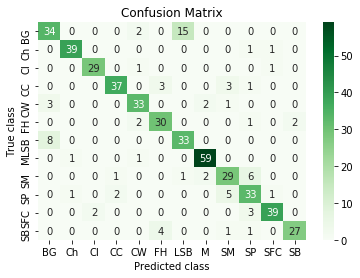

In [26]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [27]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

0it [00:00, ?it/s]

11it [00:00, 107.82it/s]

21it [00:00, 102.66it/s]

33it [00:00, 106.63it/s]

48it [00:00, 115.86it/s]

64it [00:00, 125.05it/s]

80it [00:00, 132.97it/s]

96it [00:00, 139.20it/s]

113it [00:00, 145.31it/s]

128it [00:00, 136.90it/s]

143it [00:01, 139.27it/s]

158it [00:01, 142.13it/s]

175it [00:01, 147.98it/s]

192it [00:01, 151.69it/s]

209it [00:01, 154.96it/s]

226it [00:01, 157.60it/s]

242it [00:01, 153.32it/s]

258it [00:01, 152.64it/s]

275it [00:01, 157.19it/s]

291it [00:01, 155.62it/s]

308it [00:02, 158.03it/s]

324it [00:02, 147.31it/s]

339it [00:02, 138.35it/s]

354it [00:02, 140.20it/s]

369it [00:02, 137.44it/s]

384it [00:02, 138.03it/s]

398it [00:02, 135.36it/s]

414it [00:02, 139.24it/s]

429it [00:02, 139.76it/s]

445it [00:03, 143.88it/s]

463it [00:03, 150.95it/s]

479it [00:03, 152.10it/s]

495it [00:03, 152.99it/s]

512it [00:03, 155.78it/s]

528it [00:03, 152.68it/s]

544it [00:03, 148.19it/s]

559it [00:03, 144.29it/s]

576it [00:03, 148.69it/s]

591it [00:04, 147.49it/s]

606it [00:04, 144.33it/s]

622it [00:04, 146.50it/s]

637it [00:04, 141.33it/s]

653it [00:04, 143.70it/s]

669it [00:04, 146.57it/s]

684it [00:04, 140.53it/s]

699it [00:04, 133.80it/s]

716it [00:04, 140.99it/s]

731it [00:05, 141.05it/s]

746it [00:05, 140.34it/s]

761it [00:05, 136.74it/s]

775it [00:05, 137.00it/s]

790it [00:05, 139.63it/s]

794it [00:05, 143.94it/s]

test Images shape: (794, 299, 299, 3) size: 212,953,182


In [28]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

 32/794 [>.............................] - ETA: 9:19

 64/794 [=>............................] - ETA: 7:55

 96/794 [==>...........................] - ETA: 7:05

128/794 [===>..........................] - ETA: 6:30

160/794 [=====>........................] - ETA: 6:06

192/794 [======>.......................] - ETA: 5:44

224/794 [=======>......................] - ETA: 5:24

256/794 [========>.....................] - ETA: 5:03

288/794 [=========>....................] - ETA: 4:43

320/794 [===========>..................] - ETA: 4:23

352/794 [============>.................] - ETA: 4:05

384/794 [=============>................] - ETA: 3:46

416/794 [==============>...............] - ETA: 3:29

448/794 [===============>..............] - ETA: 3:11

480/794 [=================>............] - ETA: 2:53

512/794 [==================>...........] - ETA: 2:35

544/794 [===================>..........] - ETA: 2:17

576/794 [====================>.........] - ETA: 1:59

608/794 [=====================>........] - ETA: 1:41

640/794 [=======================>......] - ETA: 1:23

672/794 [========================>.....] - ETA: 1:06

704/794 [=========================>....] - ETA: 49s 

736/794 [==========================>...] - ETA: 31s

768/794 [============================>.] - ETA: 14s

794/794 [==============================] - 430s 542ms/step


Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [29]:
test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)


In [30]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')

Total time 3742 s.
We almost used the one hour time limit.
